# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:cores-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "CORES_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
    ],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_38', 'ORACLE.run1_14', 'ORACLE.run1_8', 'ORACLE.run1_32', 'ORACLE.run1_44', 'ORACLE.run1_20', 'ORACLE.run1_50', 'ORACLE.run1_26'}


{'CORES_2', 'CORES_1', 'CORES_4', 'CORES_5', 'CORES_3'}


tensor([[[-1.3566,  0.4052, -0.1762,  ...,  0.8985, -0.0705, -0.3700],
         [-0.3700,  0.7223,  0.0529,  ...,  1.6913,  0.2995,  1.2861]],

        [[-0.0513,  1.4358, -0.1538,  ..., -0.8205, -0.4444,  0.6324],
         [ 0.3931, -2.0169, -1.2136,  ...,  0.1026, -1.0939,  0.8205]],

        [[ 0.3392,  0.2500, -0.1964,  ...,  0.2857,  0.1785, -0.2143],
         [-1.1606, -1.2141,  0.6071,  ...,  0.0536,  0.2321,  0.1250]],

        ...,

        [[ 1.2825, -0.1789,  0.4175,  ..., -0.9842, -0.1193,  1.2228],
         [ 0.2088,  1.7149,  0.1491,  ...,  0.3430, -0.4921, -1.1035]],

        [[ 0.6304, -0.7204, -0.2101,  ...,  0.3002,  0.3452,  0.1051],
         [ 0.4352, -1.0206,  0.6604,  ..., -1.6509, -0.8705,  0.1051]],

        [[ 0.8216,  0.6872, -0.6274,  ...,  0.5079,  0.5079,  0.9560],
         [-0.0896, -0.4930, -0.2988,  ...,  0.1344, -0.0149, -0.4183]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.5037, train_label_loss: 2.8087, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3213.6598, train_label_loss: 1.4395, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3396.1435, train_label_loss: 0.5660, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3625.7817, train_label_loss: 1.7894, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3867.3210, train_label_loss: 0.9682, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 3898.7562, train_label_loss: 0.6981, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3797.5734, train_label_loss: 0.9314, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 4062.5400, train_label_loss: 1.0558, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 4425.2819, train_label_loss: 0.4781, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3850.6009, train_label_loss: 0.7328, 


epoch: 1, source_val_acc_label: 0.6458, target_val_acc_label: 0.9685, source_val_label_loss: 0.9435, target_val_label_loss: 0.1504, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 1.0216, train_label_loss: 1.2200, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3892.1686, train_label_loss: 0.6996, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3971.5296, train_label_loss: 1.2158, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 3930.9570, train_label_loss: 0.6276, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3873.3875, train_label_loss: 0.6078, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3944.9481, train_label_loss: 0.7625, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3906.4465, train_label_loss: 0.4574, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 4249.2734, train_label_loss: 0.5844, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 4612.3327, train_label_loss: 1.3569, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3905.2953, train_label_loss: 0.5275, 


epoch: 2, source_val_acc_label: 0.6715, target_val_acc_label: 0.9640, source_val_label_loss: 0.8646, target_val_label_loss: 0.2174, 


epoch: 3, [batch: 1 / 33600], examples_per_second: 1.0238, train_label_loss: 0.4621, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3821.0269, train_label_loss: 0.4929, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3904.7269, train_label_loss: 1.2742, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3903.6807, train_label_loss: 0.5605, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 3873.1355, train_label_loss: 0.5932, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 3979.4777, train_label_loss: 0.8248, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 4027.8061, train_label_loss: 0.6337, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 4229.9819, train_label_loss: 1.0564, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 4309.1792, train_label_loss: 0.6078, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 4007.2409, train_label_loss: 0.9463, 


epoch: 3, source_val_acc_label: 0.6992, target_val_acc_label: 0.9680, source_val_label_loss: 0.8003, target_val_label_loss: 0.2162, 


epoch: 4, [batch: 1 / 33600], examples_per_second: 1.0117, train_label_loss: 1.2660, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3831.4858, train_label_loss: 0.4325, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3885.8983, train_label_loss: 0.9819, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3963.9356, train_label_loss: 0.3833, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3977.1675, train_label_loss: 0.6510, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3901.7168, train_label_loss: 0.5575, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3925.9575, train_label_loss: 0.7139, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 4259.6044, train_label_loss: 0.7556, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 4308.2862, train_label_loss: 0.2810, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3896.6388, train_label_loss: 0.6199, 


epoch: 4, source_val_acc_label: 0.7192, target_val_acc_label: 0.9755, source_val_label_loss: 0.7603, target_val_label_loss: 0.2201, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 1.0100, train_label_loss: 0.7138, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 3820.0263, train_label_loss: 0.5036, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3932.6812, train_label_loss: 0.5897, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3922.3925, train_label_loss: 0.7534, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3884.9478, train_label_loss: 0.5696, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3929.9576, train_label_loss: 0.8261, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3931.1443, train_label_loss: 0.6012, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 4204.4456, train_label_loss: 0.4750, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 4312.5226, train_label_loss: 0.4445, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3935.2879, train_label_loss: 0.1832, 


epoch: 5, source_val_acc_label: 0.7241, target_val_acc_label: 0.9766, source_val_label_loss: 0.7470, target_val_label_loss: 0.2444, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.9965, train_label_loss: 0.3518, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3953.0866, train_label_loss: 0.6565, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 4011.8069, train_label_loss: 0.7393, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 3957.5068, train_label_loss: 0.7706, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3835.5006, train_label_loss: 0.7325, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3949.0236, train_label_loss: 0.3984, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3998.2192, train_label_loss: 0.6525, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 4314.2012, train_label_loss: 0.2610, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 4187.4926, train_label_loss: 0.6666, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3927.0116, train_label_loss: 0.6205, 


epoch: 6, source_val_acc_label: 0.7332, target_val_acc_label: 0.9790, source_val_label_loss: 0.7412, target_val_label_loss: 0.2291, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 1.0112, train_label_loss: 0.2962, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3885.7850, train_label_loss: 0.4891, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 4009.1981, train_label_loss: 0.3208, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 3938.2025, train_label_loss: 0.6642, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3912.2287, train_label_loss: 0.1752, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3981.4990, train_label_loss: 0.5037, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 3987.0044, train_label_loss: 0.4533, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 4327.7242, train_label_loss: 0.6773, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 4250.1401, train_label_loss: 0.4815, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 4000.8020, train_label_loss: 0.5194, 


epoch: 7, source_val_acc_label: 0.7373, target_val_acc_label: 0.9808, source_val_label_loss: 0.7440, target_val_label_loss: 0.2187, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 1.0180, train_label_loss: 0.1456, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3904.7324, train_label_loss: 0.2894, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3931.4688, train_label_loss: 0.1190, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 4000.1807, train_label_loss: 0.2289, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3883.9559, train_label_loss: 0.3907, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3908.1140, train_label_loss: 0.6113, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3896.8985, train_label_loss: 0.3675, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 4297.9862, train_label_loss: 0.2367, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 4276.2952, train_label_loss: 0.3026, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3893.5876, train_label_loss: 0.0754, 


epoch: 8, source_val_acc_label: 0.7356, target_val_acc_label: 0.9794, source_val_label_loss: 0.7503, target_val_label_loss: 0.2441, 


epoch: 9, [batch: 1 / 33600], examples_per_second: 1.0052, train_label_loss: 0.2759, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3857.2286, train_label_loss: 0.3902, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3933.7117, train_label_loss: 0.2442, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 4026.5040, train_label_loss: 0.4311, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3857.9952, train_label_loss: 0.4124, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3821.2288, train_label_loss: 0.3864, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3982.5673, train_label_loss: 0.1983, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 4426.0158, train_label_loss: 0.3863, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 4254.3873, train_label_loss: 0.6091, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3903.7335, train_label_loss: 0.3956, 


epoch: 9, source_val_acc_label: 0.7353, target_val_acc_label: 0.9804, source_val_label_loss: 0.7699, target_val_label_loss: 0.2424, 


epoch: 10, [batch: 1 / 33600], examples_per_second: 1.0129, train_label_loss: 0.5530, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3876.0375, train_label_loss: 0.2710, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3971.9221, train_label_loss: 0.6449, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3887.1363, train_label_loss: 0.2747, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3884.7096, train_label_loss: 0.2972, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3943.8666, train_label_loss: 0.0749, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3992.3751, train_label_loss: 0.3536, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 4345.9680, train_label_loss: 0.4232, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 4197.4807, train_label_loss: 0.3938, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3897.5183, train_label_loss: 0.5343, 


epoch: 10, source_val_acc_label: 0.7337, target_val_acc_label: 0.9806, source_val_label_loss: 0.7866, target_val_label_loss: 0.2627, 


epoch: 11, [batch: 1 / 33600], examples_per_second: 1.0034, train_label_loss: 0.3368, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3854.2729, train_label_loss: 0.3595, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3919.6689, train_label_loss: 0.1459, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3851.4055, train_label_loss: 0.4592, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3887.9355, train_label_loss: 0.1592, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3962.5303, train_label_loss: 0.5440, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 4149.6876, train_label_loss: 0.3093, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 4424.9319, train_label_loss: 0.3927, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3994.8193, train_label_loss: 0.3640, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3882.8187, train_label_loss: 0.3072, 


epoch: 11, source_val_acc_label: 0.7287, target_val_acc_label: 0.9815, source_val_label_loss: 0.8101, target_val_label_loss: 0.2579, 


New best


epoch: 12, [batch: 1 / 33600], examples_per_second: 1.0138, train_label_loss: 0.5629, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 3913.0880, train_label_loss: 0.2053, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 4013.5518, train_label_loss: 0.3721, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3909.8428, train_label_loss: 0.2584, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 3872.9579, train_label_loss: 0.1392, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 3971.7494, train_label_loss: 0.1123, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 4160.2532, train_label_loss: 0.1870, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 4475.4975, train_label_loss: 0.0543, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 4144.8859, train_label_loss: 0.5606, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3912.7585, train_label_loss: 0.6078, 


epoch: 12, source_val_acc_label: 0.7284, target_val_acc_label: 0.9810, source_val_label_loss: 0.8271, target_val_label_loss: 0.2823, 


epoch: 13, [batch: 1 / 33600], examples_per_second: 1.0245, train_label_loss: 0.2703, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 3906.6164, train_label_loss: 0.6287, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 3980.3537, train_label_loss: 0.1353, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 3943.3662, train_label_loss: 0.1148, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3949.8696, train_label_loss: 0.4262, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 3990.3020, train_label_loss: 0.1663, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 4020.5302, train_label_loss: 0.5807, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 4585.5650, train_label_loss: 0.0517, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 4268.3432, train_label_loss: 0.1056, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 3890.6010, train_label_loss: 0.0239, 


epoch: 13, source_val_acc_label: 0.7249, target_val_acc_label: 0.9810, source_val_label_loss: 0.8627, target_val_label_loss: 0.2783, 


epoch: 14, [batch: 1 / 33600], examples_per_second: 1.0175, train_label_loss: 0.3647, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 3813.1155, train_label_loss: 0.2656, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 3876.5904, train_label_loss: 0.2914, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 3892.8392, train_label_loss: 0.1465, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 3993.5564, train_label_loss: 0.5072, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 3996.4101, train_label_loss: 0.3390, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 4052.7397, train_label_loss: 0.1516, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 4332.0178, train_label_loss: 0.2198, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 4195.3804, train_label_loss: 0.1889, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 4286.3541, train_label_loss: 0.2820, 


epoch: 14, source_val_acc_label: 0.7249, target_val_acc_label: 0.9807, source_val_label_loss: 0.8759, target_val_label_loss: 0.2932, 


epoch: 15, [batch: 1 / 33600], examples_per_second: 1.1450, train_label_loss: 0.2269, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 4767.9383, train_label_loss: 0.1794, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 5083.9173, train_label_loss: 0.2658, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 5001.4760, train_label_loss: 0.2390, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 4796.9940, train_label_loss: 0.1132, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 5036.0963, train_label_loss: 0.0326, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 4566.1824, train_label_loss: 0.1385, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 3854.5303, train_label_loss: 0.3775, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 4025.3049, train_label_loss: 0.3635, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 3940.9446, train_label_loss: 0.0554, 


epoch: 15, source_val_acc_label: 0.7238, target_val_acc_label: 0.9816, source_val_label_loss: 0.9193, target_val_label_loss: 0.2964, 


New best


epoch: 16, [batch: 1 / 33600], examples_per_second: 1.0076, train_label_loss: 0.1334, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 3856.4555, train_label_loss: 0.2076, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 3866.6091, train_label_loss: 0.3848, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 3897.5037, train_label_loss: 0.8033, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 3786.5638, train_label_loss: 0.3120, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 4291.5416, train_label_loss: 0.2732, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 4279.8703, train_label_loss: 0.5271, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 3872.4181, train_label_loss: 0.2398, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 3913.2871, train_label_loss: 0.2552, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 4043.8663, train_label_loss: 0.2581, 


epoch: 16, source_val_acc_label: 0.7193, target_val_acc_label: 0.9812, source_val_label_loss: 0.9465, target_val_label_loss: 0.3167, 


epoch: 17, [batch: 1 / 33600], examples_per_second: 1.0207, train_label_loss: 0.4648, 


epoch: 17, [batch: 3360 / 33600], examples_per_second: 3892.0359, train_label_loss: 0.1755, 


epoch: 17, [batch: 6720 / 33600], examples_per_second: 3997.2794, train_label_loss: 0.0968, 


epoch: 17, [batch: 10080 / 33600], examples_per_second: 3883.0172, train_label_loss: 0.6373, 


epoch: 17, [batch: 13440 / 33600], examples_per_second: 3858.1583, train_label_loss: 0.1939, 


epoch: 17, [batch: 16800 / 33600], examples_per_second: 4306.6926, train_label_loss: 0.2609, 


epoch: 17, [batch: 20160 / 33600], examples_per_second: 4336.8768, train_label_loss: 0.2824, 


epoch: 17, [batch: 23520 / 33600], examples_per_second: 3793.3058, train_label_loss: 0.6077, 


epoch: 17, [batch: 26880 / 33600], examples_per_second: 3870.0957, train_label_loss: 0.1626, 


epoch: 17, [batch: 30240 / 33600], examples_per_second: 3918.0186, train_label_loss: 0.1240, 


epoch: 17, source_val_acc_label: 0.7176, target_val_acc_label: 0.9799, source_val_label_loss: 0.9536, target_val_label_loss: 0.3507, 


epoch: 18, [batch: 1 / 33600], examples_per_second: 1.0132, train_label_loss: 0.1783, 


epoch: 18, [batch: 3360 / 33600], examples_per_second: 3861.3504, train_label_loss: 0.2559, 


epoch: 18, [batch: 6720 / 33600], examples_per_second: 3851.9968, train_label_loss: 0.1840, 


epoch: 18, [batch: 10080 / 33600], examples_per_second: 3870.9201, train_label_loss: 0.4211, 


epoch: 18, [batch: 13440 / 33600], examples_per_second: 3908.3652, train_label_loss: 0.1953, 


epoch: 18, [batch: 16800 / 33600], examples_per_second: 4493.5296, train_label_loss: 0.3190, 


epoch: 18, [batch: 20160 / 33600], examples_per_second: 4440.5305, train_label_loss: 0.1415, 


epoch: 18, [batch: 23520 / 33600], examples_per_second: 3913.9616, train_label_loss: 0.2933, 


epoch: 18, [batch: 26880 / 33600], examples_per_second: 3891.8381, train_label_loss: 0.1583, 


epoch: 18, [batch: 30240 / 33600], examples_per_second: 3861.5046, train_label_loss: 0.1362, 


epoch: 18, source_val_acc_label: 0.7222, target_val_acc_label: 0.9815, source_val_label_loss: 0.9926, target_val_label_loss: 0.3343, 


epoch: 19, [batch: 1 / 33600], examples_per_second: 1.0120, train_label_loss: 0.0930, 


epoch: 19, [batch: 3360 / 33600], examples_per_second: 3936.6856, train_label_loss: 0.2044, 


epoch: 19, [batch: 6720 / 33600], examples_per_second: 3951.8764, train_label_loss: 0.1991, 


epoch: 19, [batch: 10080 / 33600], examples_per_second: 4073.4232, train_label_loss: 0.2882, 


epoch: 19, [batch: 13440 / 33600], examples_per_second: 3990.6980, train_label_loss: 0.0360, 


epoch: 19, [batch: 16800 / 33600], examples_per_second: 4482.8782, train_label_loss: 0.3182, 


epoch: 19, [batch: 20160 / 33600], examples_per_second: 4456.9961, train_label_loss: 0.3602, 


epoch: 19, [batch: 23520 / 33600], examples_per_second: 3944.0238, train_label_loss: 0.2576, 


epoch: 19, [batch: 26880 / 33600], examples_per_second: 3929.8163, train_label_loss: 0.4776, 


epoch: 19, [batch: 30240 / 33600], examples_per_second: 3946.4138, train_label_loss: 0.1044, 


epoch: 19, source_val_acc_label: 0.7223, target_val_acc_label: 0.9804, source_val_label_loss: 1.0046, target_val_label_loss: 0.3566, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

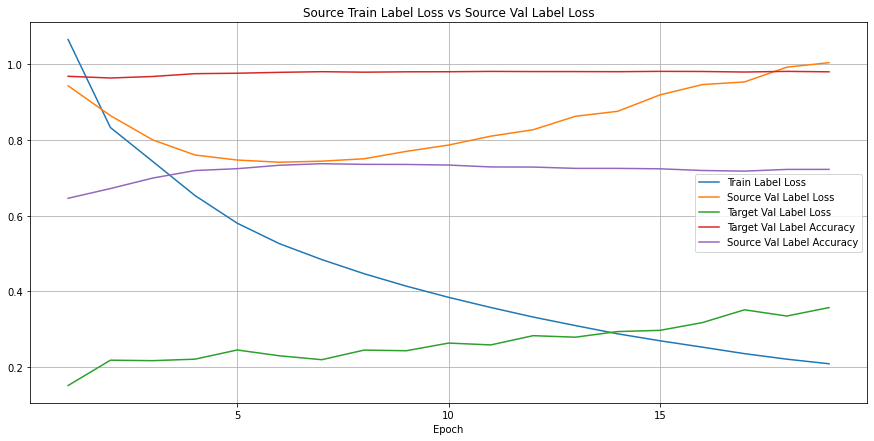

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

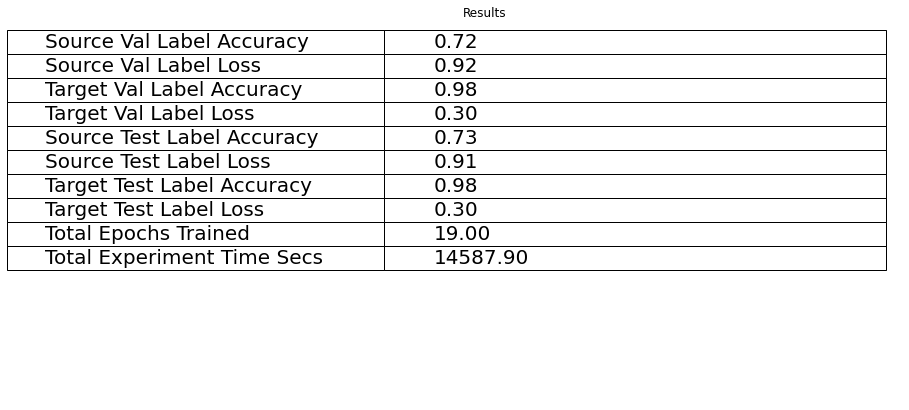

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

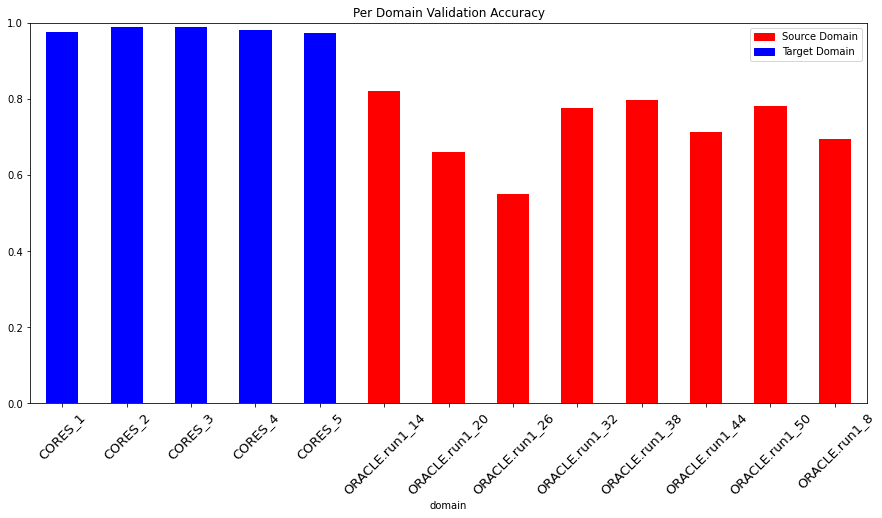

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7264973958333333 Target Test Label Accuracy: 0.9813553370786516
Source Val Label Accuracy: 0.7237760416666666 Target Val Label Accuracy: 0.9815714285714285


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:cores-oracle.run1", "parameters": {"experiment_name": "tl_1v2:cores-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL